# Real-time Memory Bandwidth of the 23 Benchmarks in SPECrate 2017 (Collected from Arm DMC-620 Memory Controller PMUs)

A helper function to convert event counts to memory bandwidth expressed in GB/s. 

In [1]:
def get_bw_series(perf_raw_data_DMC):
    
    perf_raw_data_DMC['type'] = perf_raw_data_DMC['event'].apply(
        lambda x: 'read' if x[-2:-1] == '0' else 'write'
    )
    perf_raw_data_DMC['device_id'] = perf_raw_data_DMC['event'].apply(
        lambda x: x[11:20]
    )
    perf_raw_data_DMC['socket'] = perf_raw_data_DMC['device_id'].apply(
        lambda x: 0 if x[0] == '1' else '1'
    )

    perf_raw_data_DMC = perf_raw_data_DMC.drop('event', axis=1)

    bw_all_DMC = perf_raw_data_DMC.groupby(['timestamp']).agg(value=('value', 'sum')).reset_index()
    bw_all_DMC['interval'] = bw_all_DMC['timestamp'].diff()
    bw_all_DMC.loc[0, 'interval'] = bw_all_DMC.loc[0, 'timestamp']
    bw_all_DMC['memory bandwidth (GB/s)'] = (bw_all_DMC['value'] * 64) / (bw_all_DMC['interval'] * 1000000000)

    return bw_all_DMC['memory bandwidth (GB/s)']

## Draw figures individually for each benchmark

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

save_image_path = './subfigures/'

perf_csv_dir = "../data/spec_cpu/mc/"
csv_files = os.listdir(perf_csv_dir)

benchmarks = list(set([file_name.split('.')[0] for file_name in csv_files]))
benchmarks.sort()

curves = {}

for benchmark in benchmarks:

    binaries = [binary for binary in csv_files if binary.startswith(benchmark)]
    binaries.sort()

    breaks = [0]
    bw_series = []
    for binary in binaries:
        perf_raw_data = pd.read_csv(perf_csv_dir + binary,
                                        sep='|',
                                        header=None, 
                                        names=["timestamp", "value", "event"], 
                                        usecols=[0, 1, 3])
        bw_series += list(get_bw_series(perf_raw_data))
        breaks.append(len(bw_series))
    
    curves["" + benchmark] = bw_series
    
    # Draw subfigures
    plt.figure(figsize=(8, 4))
    plt.plot(bw_series, label="Arm DMC-620")
    plt.xlabel('Timestamp (s)')
    plt.ylabel('Memory Bandwidth (GB/s)')

    for break_point in breaks:
        plt.axvline(break_point, linestyle='--', color='red', alpha=0.7)

    plt.title(f"benchmark {benchmark}")
    image_path = os.path.join(save_image_path, f"{benchmark}.pdf")
    plt.savefig(image_path, dpi=300, format='pdf', bbox_inches='tight')
    plt.close()
    print(f"Alignment figure saved to {image_path}")

Alignment figure saved to ./subfigures/500.pdf
Alignment figure saved to ./subfigures/502.pdf
Alignment figure saved to ./subfigures/503.pdf
Alignment figure saved to ./subfigures/505.pdf
Alignment figure saved to ./subfigures/507.pdf
Alignment figure saved to ./subfigures/508.pdf
Alignment figure saved to ./subfigures/510.pdf
Alignment figure saved to ./subfigures/511.pdf
Alignment figure saved to ./subfigures/519.pdf
Alignment figure saved to ./subfigures/520.pdf
Alignment figure saved to ./subfigures/521.pdf
Alignment figure saved to ./subfigures/523.pdf
Alignment figure saved to ./subfigures/525.pdf
Alignment figure saved to ./subfigures/526.pdf
Alignment figure saved to ./subfigures/527.pdf
Alignment figure saved to ./subfigures/531.pdf
Alignment figure saved to ./subfigures/538.pdf
Alignment figure saved to ./subfigures/541.pdf
Alignment figure saved to ./subfigures/544.pdf
Alignment figure saved to ./subfigures/548.pdf
Alignment figure saved to ./subfigures/549.pdf
Alignment fig

## Draw a figure that contains all benchmarks

/var/folders/f9/ylsk8vpx497_8l6sj9zjkbp40000gn/T/ipykernel_72425/1127529704.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


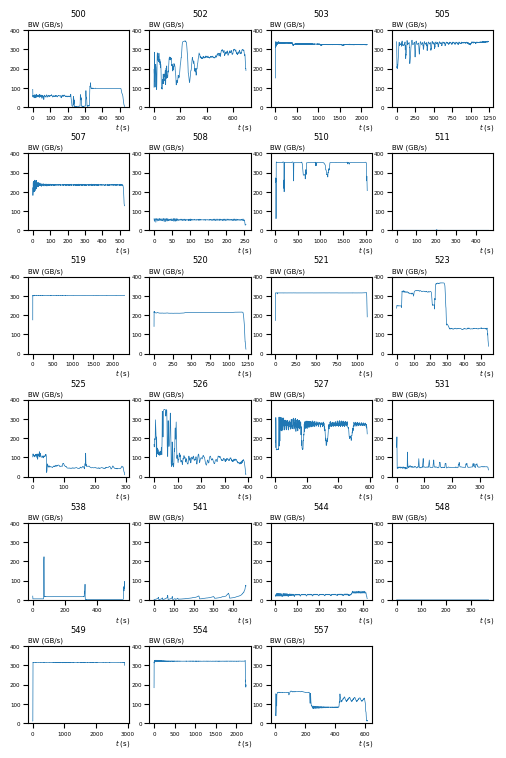

Combined figure saved to ./spec_cpu_2017_realtime_bw.pdf


In [3]:
fig, axes = plt.subplots(nrows=6, 
                         ncols=4, 
                         figsize=(6, 9), 
                         gridspec_kw={'wspace': 0.2, 'hspace': 0.6})  # 创建网格布局

axes = axes.flatten()
num_plots = len(benchmarks)

for i, benchmark in enumerate(benchmarks):
    if i >= len(axes):
        break

    ax = axes[i]
    
    bw_series = curves["" + benchmark]

    ax.plot(bw_series, label="Arm DMC-620", linewidth=0.5)
    ax.annotate('$t$ (s)', xy=(1, 0), xycoords='axes fraction', fontsize=5, xytext=(-10, -10), textcoords='offset points', ha='left', va='top')
    ax.annotate('BW (GB/s)', xy=(0, 1), xycoords='axes fraction', fontsize=5, xytext=(25, 2), textcoords='offset points', ha='right', va='bottom')

    ax.set_title(f"{benchmark}", fontsize=6, pad=10)
    ax.set_ylim(0, 400)
    ax.set_yticks(range(0, 401, 100))

    ax.tick_params(axis='both', labelsize=4)
    ax.tick_params(axis='both', labelsize=4, pad=2)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

image_path = os.path.join(".", "spec_cpu_2017_realtime_bw.pdf")

plt.tight_layout()
plt.savefig(image_path, dpi=300, format='pdf', bbox_inches='tight')
plt.show()

plt.close()
print(f"Combined figure saved to {image_path}")